In [1]:
import   cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


### Question 1 Counting objects

In [2]:
## Sample images  in Data directory
def count_objects(image_path):
    # Load the image using opencv
    image = cv2.imread(image_path)
    # Convert the image to grayscale for easy manipulation
    '''
    cv2.cvtColor(image, code) -> dst : dst is the output image; code is the color space conversion code.
    Images in opencv are stored in BGR format, so we convert it to grayscale
    '''
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply GaussianBlur to reduce noise and help contour detection
    '''
    cv2.GaussianBlur(image, ksize, sigmaX) -> dst : dst is the output image; ksize is the kernel size; sigmaX is the standard deviation in the x direction.
    '''
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Use Canny edge detection we could also use sobel
    '''  
    cv2.Canny(image, threshold1, threshold2) -> edges : edges is the output edge map; threshold1 is the first threshold for the hysteresis procedure; threshold2 is the second threshold for the hysteresis procedure.
    '''
    edges = cv2.Canny(blurred, 50, 150)
    # Find contours in the edges, this can help to detect the edges 
    ''' 
    cv2.findContours(image, mode, method) -> contours, hierarchy  : contours is a Python list of all the contours in the image; hierarchy is a numpy array that defines the hierarchy of the contours.
    '''
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Count the number of objects which should just be the number of contours you have i
    return len(contours)
    # return the number of objects

In [3]:
root = 'C:\\Users\\STUDENT\\Documents\\CMU AFRICA\\Spring 2025\\Computer Vision\\Homework 2\\'
distinct_image_path = root + 'q1_data\\1a.png'

print(f"The number of objects in the image is: {count_objects(distinct_image_path)}")
objects_touching_image_path = root + 'q1_data\\1b.png'
print(f"The number of objects in the image with objects touching each other is: {count_objects(objects_touching_image_path)}")

The number of objects in the image is: 7
The number of objects in the image with objects touching each other is: 10


### Question 2 Image Straightening 

In [4]:

def find_lines(image_path):
    # Load the image using opencv
    img = cv2.imread(image_path)
    # Convert the img to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Preprocessing Steps
    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Contrast Enhancement using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)
    # Apply Canny Edge Detection
    edges = cv2.Canny(enhanced, 50, 150)
    #Optional to enhance the edges using morphological operations. Should be applied with care
    # Apply Morphological Operations (Dilation + Erosion)
    # kernel = #Not implemented
    # dilated = #not implemented
    # eroded = #Not implemented
    # Apply Hough Transform to detect lines
    # This returns an array of r and theta values
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    # The below for loop runs till r and theta values
    # are in the range of the 2d array
    angles_count = {}
    for r_theta in lines:
        arr = np.array(r_theta[0], dtype=np.float64)
        
        r, theta = arr
        #Convert Polar Coordinates to Cartesian Coordinates
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*r
        y0 = b*r
        #Store the angles in a dictionary to count the number of lines corresponding to that angle
        if theta in angles_count.keys():
            angles_count[theta] += 1
        else:
            angles_count[theta] = 1
        # Second point needed to draw the line
        
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))

        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        # Draw the line on the image
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    cv2.imwrite('linesDetected.jpg', img)
    # return the angles_count dictionary
    return angles_count


angles_count = find_lines('q2_data/2b.jpg')
top_3_angles = sorted(angles_count, key=angles_count.get, reverse=True)[:3]
print(f"The top 3 angles with the most lines are: {top_3_angles}")
img = cv2.imread('linesDetected.jpg')

The top 3 angles with the most lines are: [np.float64(0.593411922454834), np.float64(0.7853981852531433), np.float64(0.6108652353286743)]


In [5]:
# convert top angle go degrees for rotation
angle = top_3_angles[0] * 180 / np.pi

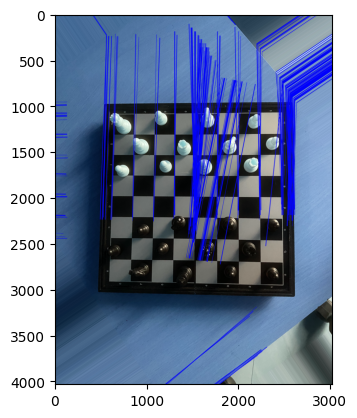

In [ ]:
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return rotated
rot_img = rotate_image(img, angle)
#show rot_img
plt.imshow(rot_img,cmap='gray')

### Question 3 Image compression

In [7]:
## Sample images  in Data directory
def compress_image(image_path, compress_ratio):
    # Load image using imread
    image = cv2.imread(image_path)
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Use numpy to get the fast fourier transform of the grayscale image
    ''' 
    np.fft.fft2(gray) -> fft : fft is the output array of the Fourier Transform.
    it outputs a 2D array of complex numbers same shape as the image
    '''
    fft = np.fft.fft2(gray)
    # Sort the absolute value of  the frequencies. You will have to flatten the frequencies => fSorted
    ''' 
    Since the Fourier Transform is a complex number, we take the absolute value of the Fourier Transform to get the magnitude of the frequency components.
    The resultant is a 2D array of real numbers when we take the absolute value, we flatten it to a 1D array to sort it.
    '''
    fSorted = np.sort(np.abs(fft).flatten())
    # Determine the threshold to keep using thresh = fSorted[int(np.floor((1-compress_ration)*len(fSorted)))]
    '''
    We determine the threshold to keep by taking the floor of the product of the compress ratio and the length of the sorted frequencies.
    We use the threshold to filter the frequencies
    '''
    thresh = fSorted[int(np.floor((1-compress_ratio)*len(fSorted)))]
    # create a mask to help filter. mask = np.abs(computed_fourier) >  thresh
    '''
    We create a mask to filter the frequencies. We compare the absolute value of the computed Fourier Transform to the threshold.
    '''
    mask = np.abs(fft) > thresh
    # filter the Fourier using the mask filtered = computer_fourier * mask
    '''
    We filter the Fourier Transform by element-wise multiplication of the mask and the computed Fourier Transform.
    '''
    filtered = fft * mask
    # apply inverse fourier to get a compressed version of the image
    '''
    np.fft.ifft2(filtered) -> compressed : compressed is the output array of the Inverse Fourier Transform.
    '''
    compressed = np.fft.ifft2(filtered)
    # return the image obtained.
    return np.abs(compressed)

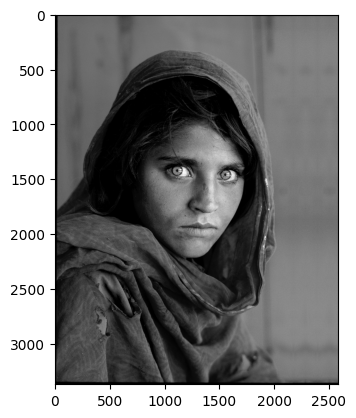

In [8]:
image_path = 'q3_data/q3a.jpg'
compress_ratio = 1.8
plt.imshow(compress_image(image_path, compress_ratio), cmap='gray')

# PLAYGROUND

The block below is just me trying to understand what happens in my code

The image has shape: (3372, 2587, 3), datatype: uint8
The image in spatial domain has shape: (3372, 2587), datatype: uint8 and the fourier transform has shape: (3372, 2587), datatype: complex128


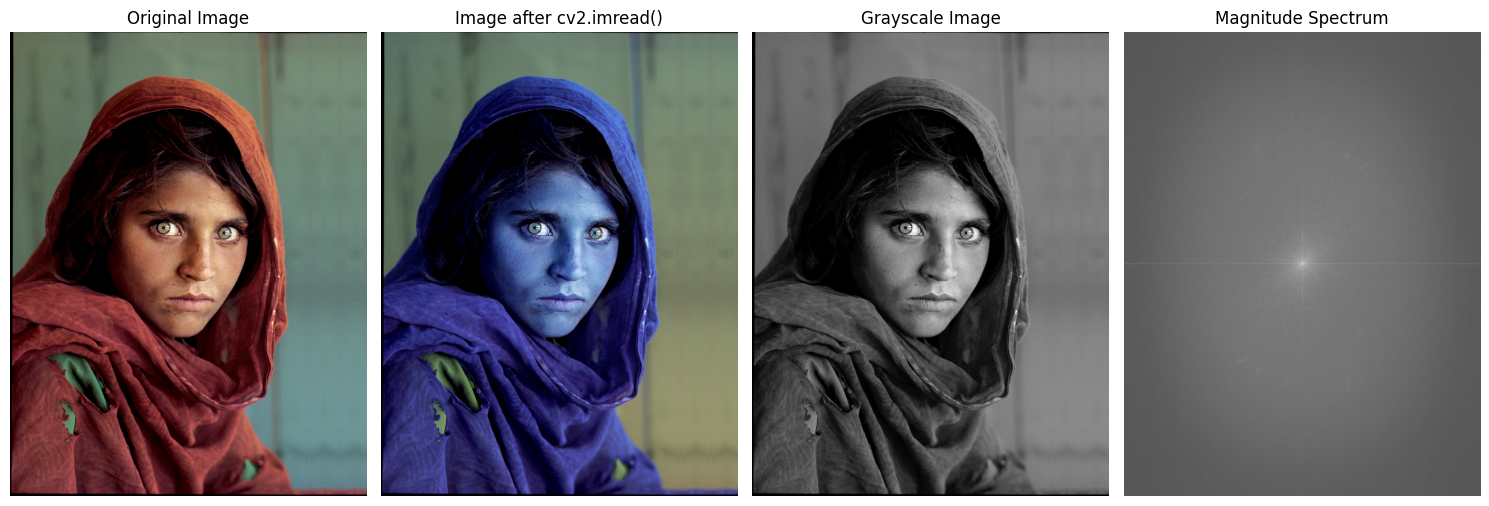

In [9]:
# PLAYGROUND
image_path = 'q3_data/q3a.jpg'
''' 
cv2.imread(image_path) -> image : image is the output image.

it automatically loads the image as a numpy array in BGR format - H x W x C where H is the height of the image, W is the width of the image and C is the number of channels in the image.
'''
image = cv2.imread(image_path)
print(f"The image has shape: {image.shape}, datatype: {image.dtype}")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
'''
np.fft.fft2(image) -> fft : fft is the output image; image is the input image.

what fourier transform does is that it converts the image from spatial domain to frequency domain; spatial domain is the image itself - the location of pixels in the image
The frequency domain on the other hand is the representation of the image in terms of frequencies. It is a 2D array of complex numbers. The magnitude of the complex numbers in the frequency domain is the frequency of the image.

The fourier transform resultant is a 2D array of complex numbers same shape as the input image. Each complex number represents the frequency of the image at that point in the image.

To visualize the fourier transform - 2D array of complex numbers, we can use the magnitude of the complex numbers to represent the frequencies. This is done by taking the log of the magnitude of the complex numbers.

'''
fft = np.fft.fft2(gray)
print(f"The image in spatial domain has shape: {gray.shape}, datatype: {gray.dtype} and the fourier transform has shape: {fft.shape}, datatype: {fft.dtype}")
# plotting the fourier transform to understand the frequencies
fshift = np.fft.fftshift(fft)
magnitude_spectrum = 20*np.log(np.abs(fshift))


# Create a figure with 3 subplots
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 4, 1)  # 1 row, 4 columns, first subplot
plt.imshow(Image.open(image_path))
plt.title("Original Image")
plt.axis('off')


# Image after cv2.imread()
plt.subplot(1, 4, 2)  # 1 row, 3 columns, first subplot
plt.imshow(image)
plt.title("Image after cv2.imread()")
plt.axis('off')

# Grayscale Image
plt.subplot(1, 4, 3)  # 1 row, 3 columns, second subplot
plt.imshow(gray, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')

# Fourier Transform Magnitude Spectrum
plt.subplot(1, 4, 4)  # 1 row, 3 columns, third subplot
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title("Magnitude Spectrum")
plt.axis('off')

# Display the images
plt.tight_layout()
plt.show()

### Question 4 Data Augmentation

In [10]:
## Use your own images to test.
def data_augmentation(img, type):
    if type=="resize1":
        # resize the  image to 224 x 224 use nearest neighbor 
        return cv2.resize(img, (224, 224), interpolation=cv2.INTER_NEAREST)
    elif type=="resize2":
        # resize the  image to 224 x 224 use cubic spline interpolation
        return cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
    elif type=="vertical_flip":
        # flip the image vertically
        return cv2.flip(img, 0)
    elif type=="horizontal_flip":
        # flip the image horizontally
        return cv2.flip(img, 1)
    elif type=="blur_noise":
        # flip the image horizontally
        return cv2.GaussianBlur(img, (5, 5), 0)
    elif type=="rotation":
        # use your own parameters
        return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    elif type=="shear on y-axis":
        # use your own parameters
        return cv2.warpAffine(img, np.float32([[1, 0.5, 0], [0, 1, 0]]), (img.shape[1], img.shape[0]))
    elif type=="shear on x-axis":
        # use your own parameters
        return cv2.warpAffine(img, np.float32([[1, 0, 0], [0.5, 1, 0]]), (img.shape[1], img.shape[0])

SyntaxError: incomplete input (2212577924.py, line 26)